In [ ]:
install.packages("cluster")
install.packages("factoextra")
install.packages("fpc")
install.packages("dbscan")
library(cluster)
library(factoextra)
library("fpc")
library("dbscan")

In [2]:
complex8 <- read.csv("Complex8.data", header=FALSE)
dataset <- read.csv("Pima.csv", header = FALSE)

# 0.

### The Pima dataset was transformed to ZPima by z-scoring the first 8 attributes of the dataset 
### z = (x – μ) / σ


In [3]:
ZPima <- scale(dataset[,1:8])
ZPima <- cbind(ZPima, dataset[,9])

# 1.

### For each cluster Ci we have proportions pi=(pi1,…,pim) of examples belonging to the m different classes  (for cluster numbers i=1,..,k);

In [4]:
entropyvec <- function(vec) {
  s <- sum(vec)
 
  totalh <- Reduce(function(acc, elem) {
    prob <- elem / s
    h <- if (prob == 0) 0 else prob * log2(prob)
    return (acc - h)
  }, vec, 0)
 
  return (totalh)
}

entropy <- function(clusterassignment, groundtruth) {
  clusterlevels <- clusterassignment
  clusterclass <- table(clusterassignment, groundtruth)

  n <- nrow(clusterclass)
  entropy_weight <- array(dim=c(n, 2))
  population <- 0
 
  for (i in 1:n) {
    clustersize <- sum(clusterclass[i,])
    population <- population + clustersize
    entropy_weight[i,] = c(entropyvec(clusterclass[i,]), clustersize)
  }
  percentage <- 0
  outliers <- sum(clusterclass[1,])
  entropy_weight[1,] = c(0, 0)
  percentage <- outliers / population
  population <- population - outliers
 
  totalh <- 0
  if (population > 0) {
    for (i in 1:n) {
      totalh <- totalh + entropy_weight[i, 1] * entropy_weight[i, 2] / population
    }
  }
 
  return (c(totalh, percentage))
}

### Testing entropy function

In [5]:
a1 <- c(0,1,1,1,1,2,2,3)
a2 <- c('1','1','1','0','0','2','2','2')
b <- c('A','A','A','E','E','D','D','C')
print(entropy(a1, b))
print(entropy(a2, b))

[1] 0.5714286 0.1250000
[1] 0.4591479 0.2500000


# 2.

### wabs-dist(u,v,w) takes two vectors u, v as an input and computes the distance between u and v as the sum of the absolute weighted differences

In [6]:
wabs_dist <- function(u,v,w){
   return(sum((abs(u-v))*w))
} 

### Testing entropy function

In [7]:
wabs_dist(c(1,2), c(4,5), c(0.2,0.3))
wabs_dist(c(4,5),c(9,12), c(0.2,0.3))

[1] 1.5

[1] 3.1

# 3.

### create-dm(x,w) that returns a distance matrix for the objects in dataframe x

In [8]:
# 3. Write an R-function create-dm(x,w) that returns a distance matrix for the objects in dataframe x by calling the 
# wabs-dist(a,b,w) for all pairs of objects a and b belonging to x. **
create_dm <- function(x,w){
    rows <- nrow(x)
    data <- matrix(nrow = rows, ncol = rows)
    for(i in 1:rows){
        for(j in 1:rows){
            data[i,j] <- wabs_dist(as.numeric(as.vector(x[i,])), as.numeric(as.vector(x[j,])), w)
            data[j,i]=data[i,j];
        }
        data[i,i] = 0
    }
    
    return(data)
}

### Tesing create-dm(x,w) function

In [9]:
print(create_dm(data.frame("x" = c(1,4,9), "y" = c(2,5,12)), c(0.2,0.3)))

     [,1] [,2] [,3]
[1,]  0.0  1.5  4.6
[2,]  1.5  0.0  3.1
[3,]  4.6  3.1  0.0


# 4.

In [35]:
k6 <- kmeans(ZPima[,1:8], 6 , nstart=20)
k9 <- kmeans(ZPima[,1:8], 9 , nstart=20)

pA <- create_dm(as.data.frame(ZPima[,1:8]), c(1,1,1,1,1,1,1,1))
pB <- create_dm(as.data.frame(ZPima[,1:8]), c(0.2,1,0,0,0,1,0.2,1))
pC <- create_dm(as.data.frame(ZPima[,1:8]), c(0,1,0,0,0,1,0,0))

pamA <- pam(x = pA, k = 6)
pamB <- pam(x = pB, k = 6)
pamC <- pam(x = pC, k = 6)
overall_entropy <- mean(c(
    entropy(k6$cluster, ZPima[,9])[1], 
    entropy(k9$cluster, ZPima[,9])[1], 
    entropy(pamA$clustering, ZPima[,9])[1], 
    entropy(pamB$clustering, ZPima[,9])[1], 
    entropy(pamC$clustering, ZPima[,9])[1])
)

### The over all entropy:

In [47]:
overall_entropy

[1] 0.7330442

## K-means k = 6
### The entropy of the k-means model with k = 6:

In [48]:
entropy(k6$cluster, ZPima[,9])[1]

[1] 0.7704272

### The majority class is in cluster 5 with 257 points.
### Centroid:

In [49]:
k6$centers

V1,V2,V3,V4,V5,V6,V7,V8
-0.05828725,1.27917176,-0.2017728,0.3719967,3.30841174,0.4171425,0.0626941,-0.04576294
0.37438079,1.02094673,0.6015897,-0.1223136,0.03589029,-0.2177067,-0.2507765,1.28079054
1.43243562,-0.34893265,0.2886044,0.2273629,-0.08894374,0.1220538,-0.2158968,0.66886309
-0.59823033,-0.06870955,0.1575614,0.8075379,-0.12493192,0.9592841,-0.1402284,-0.50786353
-0.51354429,-0.57235020,-0.5573820,-0.7195206,-0.40879553,-0.7329717,-0.2362116,-0.66881263
-0.05131828,0.49013587,0.1875743,0.3438743,0.14386695,0.3812480,2.2838773,0.16909725


## K-means k = 9
### The entropy of the k-means model with k = 9:

In [50]:
entropy(k9$cluster, ZPima[,9])[1]

[1] 0.7495953

### The majority class is in cluster 5 with 257 points.
### Centroid: 

In [51]:
k9$centers

V1,V2,V3,V4,V5,V6,V7,V8
-0.1075189,1.3244596,-0.1231885,0.4583957,3.807447288,0.40135073,0.3920046,-0.002890153
-0.5458160,-0.6938573,-0.7788949,-0.8861597,-0.460133174,-0.91738849,-0.2595605,-0.750760789
-0.6520259,-0.5412283,-0.3289110,0.5591859,-0.331872052,0.60335526,-0.2939568,-0.640878999
1.1710241,-0.5898430,0.1483965,0.2348541,-0.093613343,0.01824662,-0.3684448,0.505944433
-0.3217562,-0.2947635,-0.2781747,-0.1359344,-0.188274459,0.03781007,2.1671439,-0.135091856
-0.3138201,0.6987442,0.3286956,-0.2629456,-0.004039576,-0.22518896,-0.3230497,-0.180765248
0.5555381,0.4119342,0.3657711,-0.2462316,0.014709692,-0.77991948,-0.1927314,2.224049833
-0.6565804,0.8617953,0.9128031,1.3852048,0.330134565,1.73944075,0.5530647,-0.318963915
1.3916266,1.1318252,0.9906174,0.3118159,0.160945648,0.63973370,0.4104285,1.048827738


## PAM A  k = 6
### The entropy of the PAM model with k = 6:

In [52]:
entropy(pamA$clustering, ZPima[,9])[1]

[1] 0.7549239

### The majority class is in cluster 5 with 257 points.
### Medoids: 

In [53]:
data.frame( Means=rowMeans(as.data.frame(pamA$medoids)))

Means
<dbl>
8.573948
6.849404
8.744534
12.591581
6.930193
8.549361


## PAM B k = 6
### The entropy of the PAM model with k = 6 is:

In [54]:
entropy(pamB$clustering, ZPima[,9])[1]

[1] 0.7156704

### The majority class is in cluster 5 with 257 points.
### Medoids:

In [55]:
data.frame( Means=rowMeans(as.data.frame(pamB$medoids)))

Means
<dbl>
4.026482
3.439300
5.025095
4.105502
2.864324
3.298526


## PAM C k = 6
### The entropy of the PAM model with k = 6 is:

In [56]:
entropy(pamC$cluster, ZPima[,9])[1]

[1] 0.6746042

### The majority class is in cluster 5 with 257 points.
### Medoids:

In [57]:
data.frame( Means=rowMeans(as.data.frame(pamC$medoids)))

Means
<dbl>
2.574261
3.003578
4.046172
3.811711
3.278444
2.649435


## Visualization 
### K-Mmeans, K = 6 


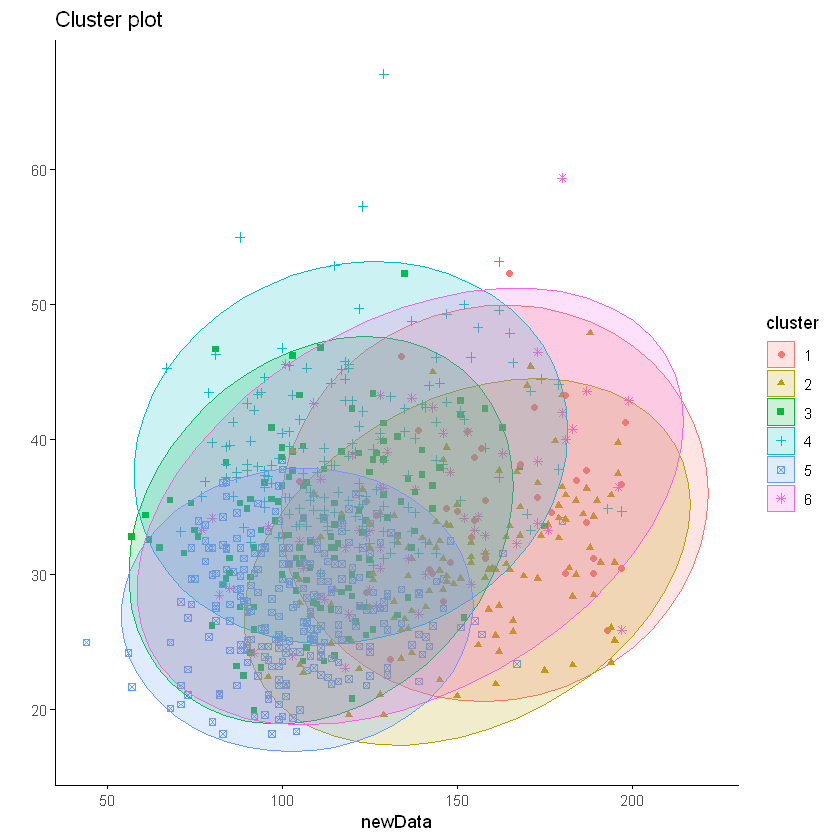

In [58]:
newData <- dataset[,2]
newData <- cbind(newData, dataset[,6])
fviz_cluster(k6, 
             data = newData, 
             stand = FALSE, 
             ellipse.type = "norm", 
             show.clust.cent = FALSE, 
             geom = "point", 
             ggtheme = theme_classic())

### K-Mmeans, K = 9

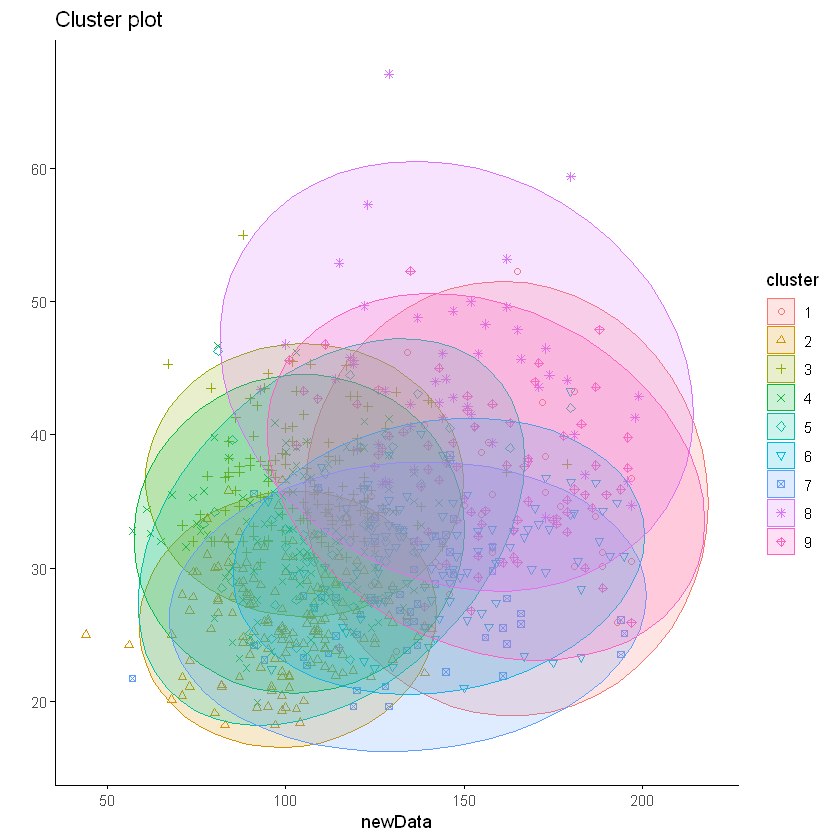

In [59]:
fviz_cluster(k9, 
             data = newData, 
             stand = FALSE, 
             ellipse.type = "norm", 
             show.clust.cent = FALSE, 
             geom = "point", 
             ggtheme = theme_classic())

### PAM, W = (1,1,1,1,1,1) k = 6

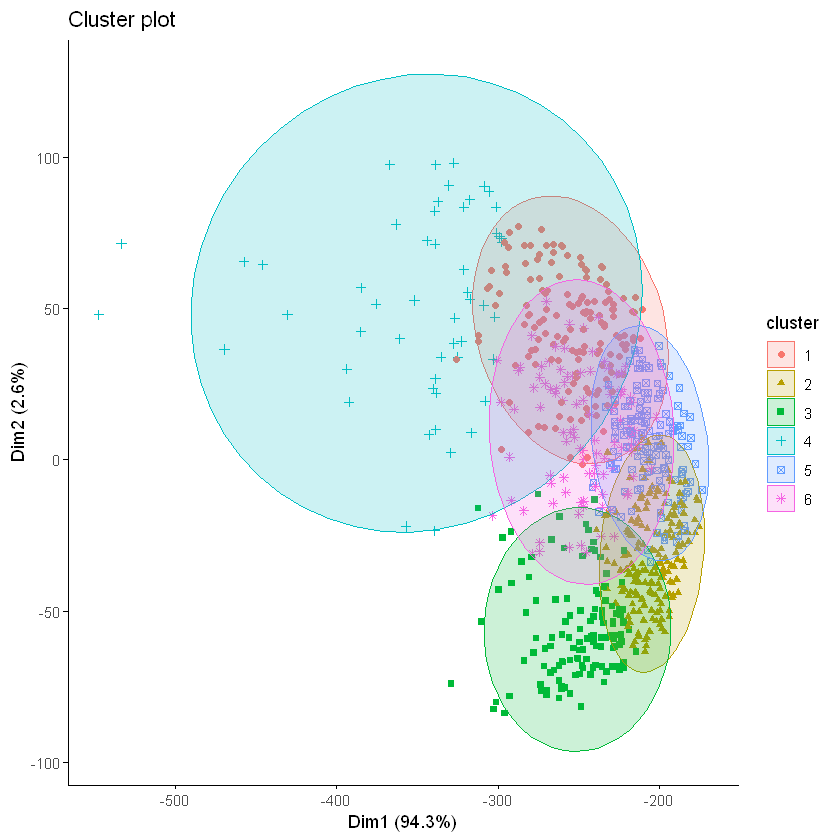

In [60]:
fviz_cluster(pamA, 
             data = newData, 
             stand = FALSE, 
             ellipse.type = "norm", 
             show.clust.cent = FALSE, 
             geom = "point", 
             ggtheme = theme_classic())

### PAM, W = (0.2,1,0,0,0,1,0.2,1) k = 6

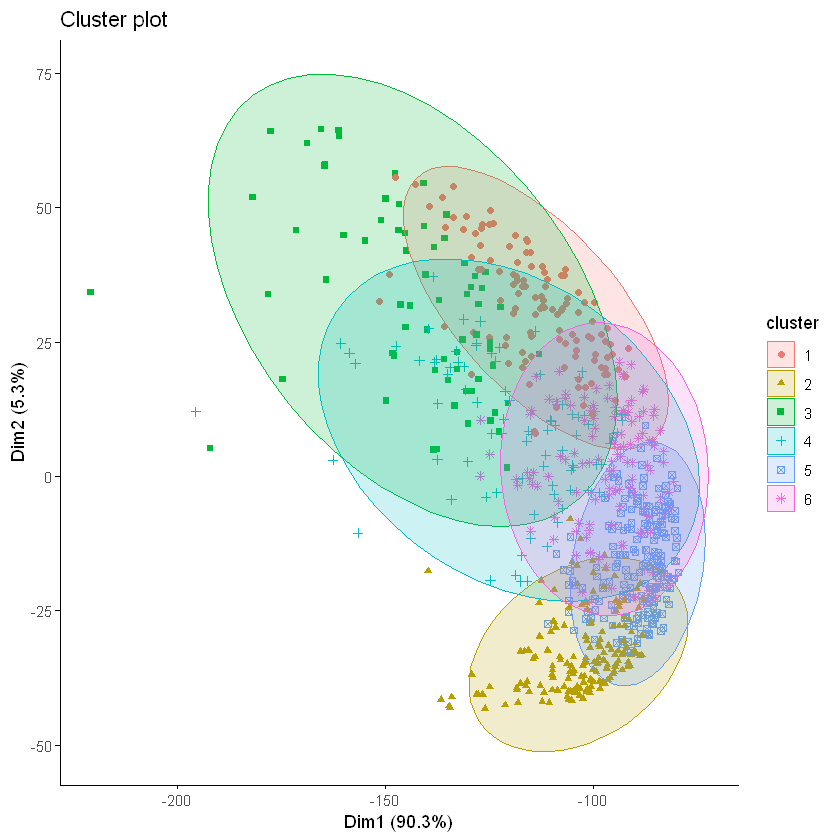

In [61]:
fviz_cluster(pamB, 
             data = newData, 
             stand = FALSE, 
             ellipse.type = "norm", 
             show.clust.cent = FALSE, 
             geom = "point", 
             ggtheme = theme_classic())

### PAM, W = (0,1,0,0,0,1,0,0) k = 6

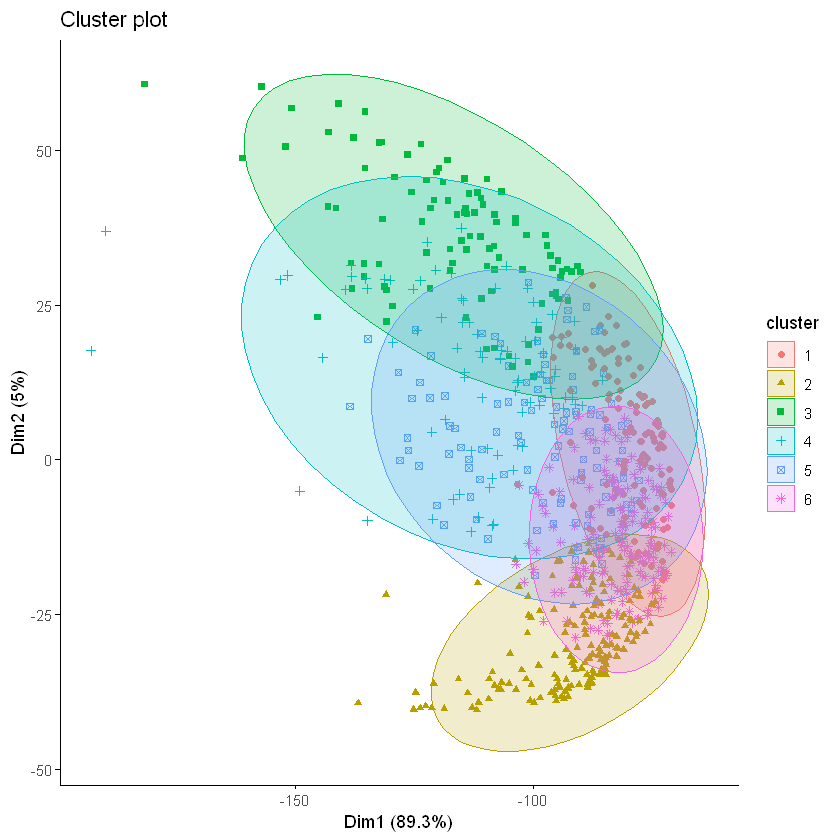

In [62]:
fviz_cluster(pamC, 
             data = newData, 
             stand = FALSE, 
             ellipse.type = "norm", 
             show.clust.cent = FALSE, 
             geom = "point", 
             ggtheme = theme_classic())

#### From all of these clustering result, PAM clustering with weight (0,1,0,0,0,1,0,0) achieved the best result with the lowest entropy of 0.674604229969899. From the PAM with the weight (0,1,0,0,0,1,0,0), the cluster group is slightly less overlapped in comparison to others. By changing the distance function, we can see that it affect the clustering location of the data points. First PAM is more populated around the right side and the cluster on the top was able to pick up more points compared to the second PAM and is more populated around the center of the graph. The third PAM is more populated around the bottom left of the graph. Based on the distance function given for the first PAM, we see that giving all of the attributes the same weight doesn’t produce the best result because some attributes are more important than the others. In the third PAM model, we only give a weight of 1 to the 2nd and 6th attributes. Since this model only considers 2nd and 6th attributes and still produced the best result, we can conclude that the 2nd and 6th attributes are the most important attribute. In terms of difficulty in diagnosing diabetes, it is fairly hard to do so since our clustering results have high entropy results and you can see a lot of overlapping data points in the resulting graphs.

# 6.

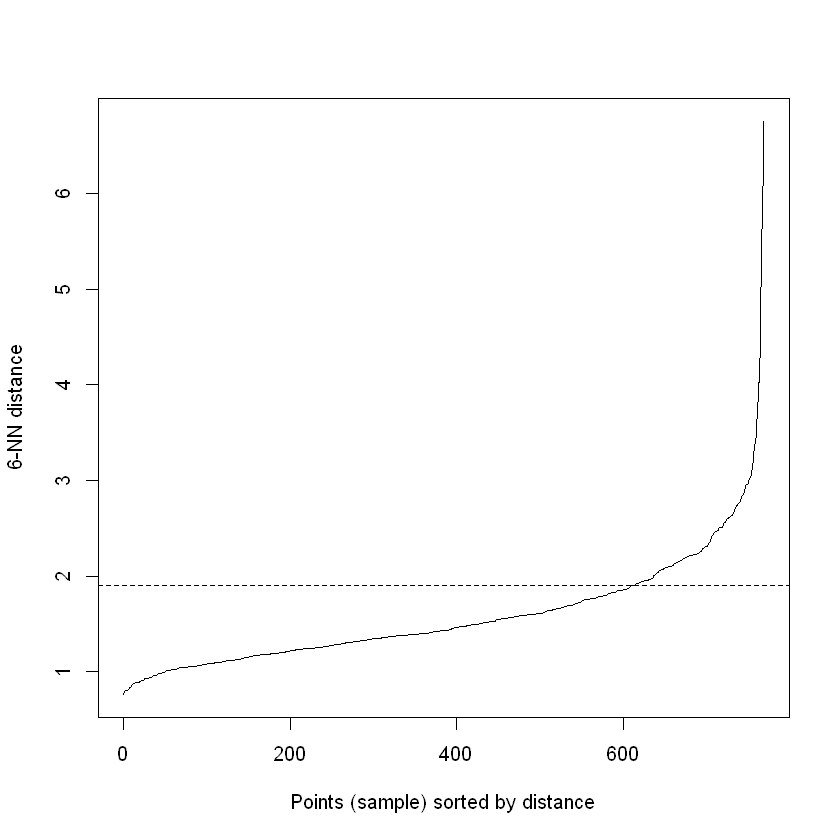

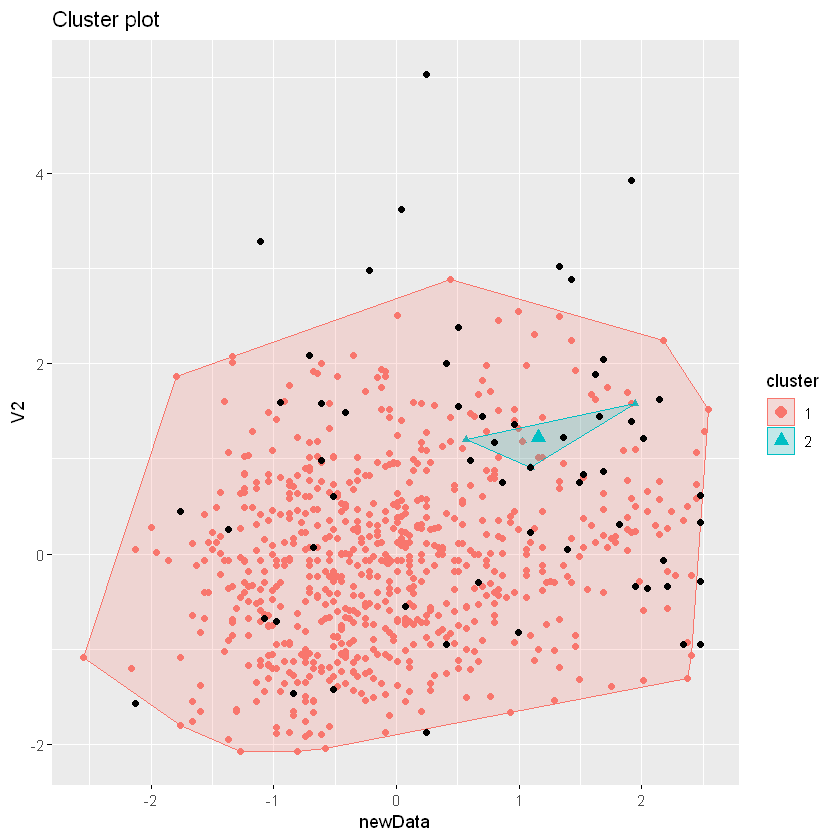

In [69]:
dbscan::kNNdistplot(ZPima[,1:8], k=6)
abline(h =1.9, lty = 2)
db <- fpc::dbscan(ZPima[,1:8], eps = 1.9, MinPts = 3)
newData <- dataset[,2]
newData <- cbind(newData, dataset[,6])
fviz_cluster(db, as.data.frame(newData), geom = "point")

### Entropy:

In [65]:
entropy(db$cluster, ZPima[, 9])[1]

[1] 0.9138972

#### I utilized kNNDistplot with k being 6 to find the ideal epsilon value for this DBScan algorithm. From the kNNDistplot, the graph will tell me where the shift in the slope of the graph. I decided to go with the epsilon value of 1.9 as stated on the 6-NN graph. Furthermore, I picked the MinPts as 3 since picking any smaller numbers would build more clusters from noise. I visulizied the clustering result for the Plasma glucose/Body mass index attribute. DBScan doesn’t do a great job classify the data since 707 data points fall under cluster 1 and only 4 data points fall under cluster 2. There’s also a complete overlap in the graph which make this a bad clustering result. However, I was able to minimize the outlier to only 7.4% only.

# 7.

In [33]:
ZComplex8 <- scale(complex8[,1:2])
ZComplex8 <- cbind(ZComplex8, complex8[,3])

complex8_k8 <- kmeans(ZComplex8[,1:2], 8, nstart = 20)
complex8_k11 <- kmeans(ZComplex8[,1:2], 11, nstart = 20)

### K-means with nstart=20 for k=8

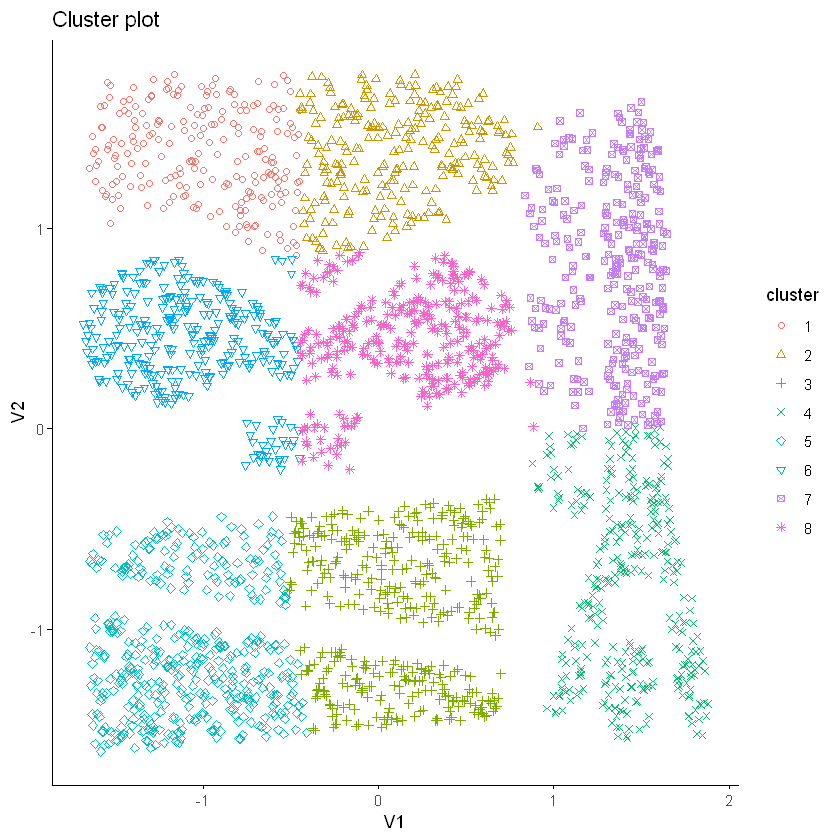

In [25]:
fviz_cluster(complex8_k8, 
             data = ZComplex8[,1:2], 
             stand = FALSE, 
             ellipse = FALSE, 
             show.clust.cent = FALSE, 
             geom = "point", 
             ggtheme = theme_classic())

### K-means with nstart=20 for k=11

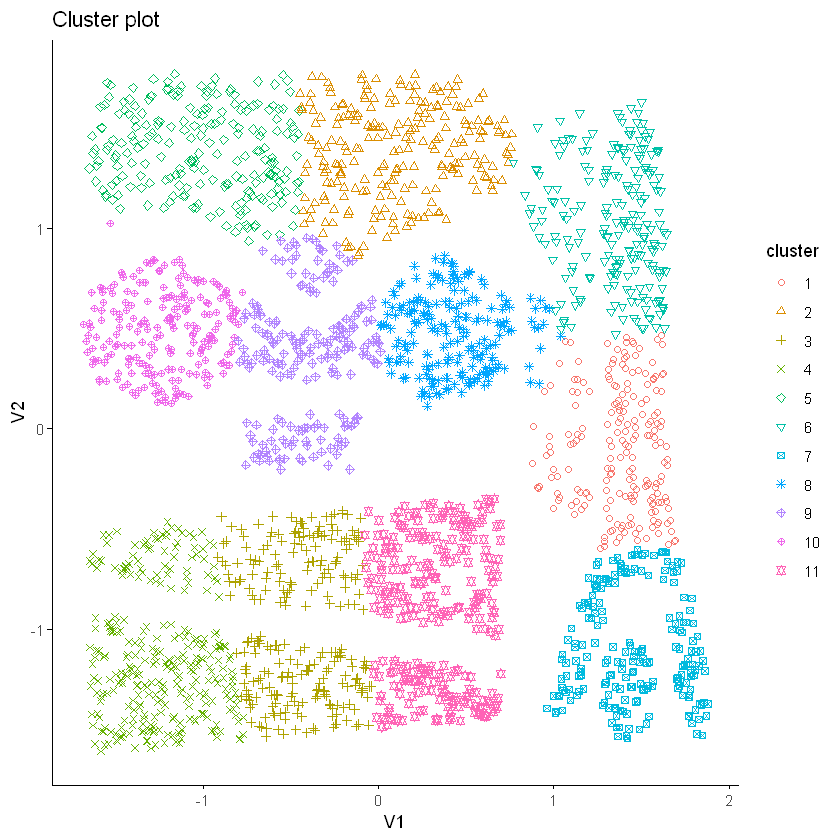

In [26]:
fviz_cluster(complex8_k11, 
             data = ZComplex8[,1:2], 
             stand = FALSE, 
             ellipse = FALSE, 
             show.clust.cent = FALSE, 
             geom = "point", 
             ggtheme = theme_classic())

### Entropy for k = 8:

In [27]:
cat(entropy(complex8_k8$cluster, complex8$V3)[1], "\n")

0.7916596 


### Entropy for k = 11:

In [28]:
cat(entropy(complex8_k11$cluster, complex8$V3)[1])

0.6472274

#### From the result for k = 8 the entropy I obtained is 0.7916596 and for k = 11 I obtained 0.6472274. From the visualization, the k = 11 has more clustering and was able to group more different points than for k = 8. There is less data overlapping in the second k-mean clustering model. In conclusion, the best K-Mean clustering out of the two is when k = 11.

# 8.

Model#  1 using Epsilon= 0.09 and minPts= 2 : 
 Entropy:  0.03289668 , Outlier Percentage:  0.5488044 
Model#  2 using Epsilon= 0.09 and minPts= 3 : 
 Entropy:  0.03292264 , Outlier Percentage:  0.627205 
Model#  3 using Epsilon= 0.09 and minPts= 4 : 
 Entropy:  0.0330138 , Outlier Percentage:  0.9016072 
Model#  4 using Epsilon= 0.09 and minPts= 5 : 
 Entropy:  0 , Outlier Percentage:  1.803214 
Model#  5 using Epsilon= 0.09 and minPts= 6 : 
 Entropy:  0.004035549 , Outlier Percentage:  3.057624 
Model#  6 using Epsilon= 0.09 and minPts= 7 : 
 Entropy:  0.00413438 , Outlier Percentage:  5.448844 
Model#  7 using Epsilon= 0.09 and minPts= 8 : 
 Entropy:  0 , Outlier Percentage:  9.95688 
Model#  8 using Epsilon= 0.1 and minPts= 2 : 
 Entropy:  0.07890235 , Outlier Percentage:  0.2744022 
Model#  9 using Epsilon= 0.1 and minPts= 3 : 
 Entropy:  0.07896443 , Outlier Percentage:  0.3528028 
Model#  10 using Epsilon= 0.1 and minPts= 4 : 
 Entropy:  0.07896443 , Outlier Percentage:  0.35280

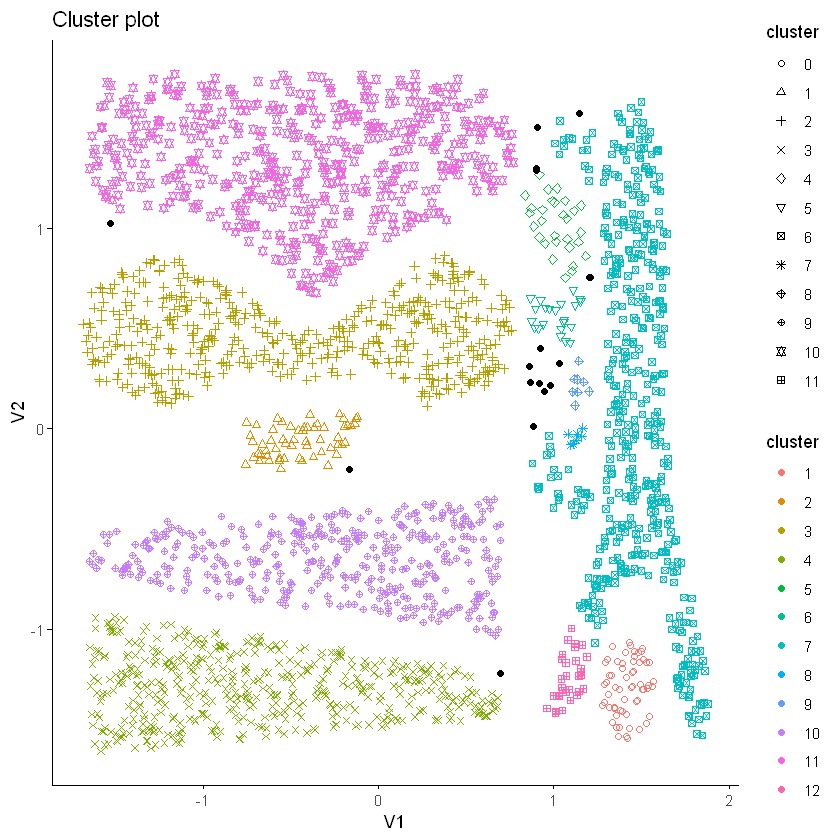

In [81]:
eps <- c(0.09,0.10,0.13,0.15,0.2,0.25,0.30)
minpts <- c(2,3,4,5,6,7,8)

entropyResult <- c()
outliers <- c()
counter <- 1

for (i in 1:length(eps)){
    for(j in 1:length(minpts)){
        complexDB <- dbscan(ZComplex8[,1:2], eps=eps[i], minPts = minpts[j])
        clusterResult <- complexDB$cluster
        en <- entropy(clusterResult, ZComplex8[,3])[1]
        entropyResult[counter] <- en
        outlierR <- entropy(clusterResult, ZComplex8[,3])[2] * 100
        outliers[counter] <- outlierR
        counter <- counter + 1
    }
  }

index <- 1
for(i in 1:length(eps)){
    for(j in 1:length(minpts)){
        cat("Model# ", index,"using Epsilon=", eps[i], "and minPts=", minpts[j], ": \n",
            "Entropy: ",entropyResult[index], ", Outlier Percentage: ", outliers[index], "\n")
        index <- index + 1
    }
}

complexDB <- dbscan(ZComplex8[,1:2], eps=.1, minPts = 5)
fviz_cluster(complexDB, ZComplex8[,1:2],
             stand = FALSE, 
             ellipse = FALSE, 
             show.clust.cent = FALSE, 
             geom = "point", 
             ggtheme = theme_classic())

### Entropy:

In [30]:
entropy(complexDB$cluster, ZComplex8[,3])[1]

[1] 0.07768245

#### To determine the best epsilon and the Minpoint value, I created a vector of epsilon that ranges from 0.9 to 0.30 and a vector of minpts. I run this comboniation of epsilon and minpts values and storing the result in an entropyResult and an outliers vector. I analysed the result the choose the best epsilon and minpts values. I chose to used the epsilon value of 0.1 and minpts value of 5 and got an entropy of 0.07768245  and minpts of 5. The result for the K-means from number 7, for k = 8 I received an entropy of 0.7916596 and for k = 11 I received an entropy of 0.6472274. From these results, we can see that the DBSCAN gives better result compare to K-means clustering. The best entropy that we for K-means is 0.6472274 which is worse than 0.07768245 entropy for DBSCAN. The DBSCAN was able to cluster the data into 23 groups while k-means was able to cluster into 11 groups. 

## 9.

#### K-Means, PAM, and DBSCAN had a hard time clustering the Pima dataset while having a much easier time in clustering the data in Complex8 data. This just tells us that it is really hard to identify diabetes. From using PAM we see the most important attributes for identifying diabetes which is the 2nd and 6th attributes. However, when we use these two attributes with DBSCAN rather than PAM, we see that the result is not nearly as good as PAM. We can conclude that PAM is the best clustering technique for Zima Dataset. Using  DBSCAN on the Complex8 dataset there was less overlapping and easy to visualize where the cluster groups. The two attributes from task 4 show the importance of Plasma glucose and Body mass index are vital for diabetes.